In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# General

In [2]:
import json
import requests

### Helper methods

In [3]:
import time

def get_unix_time_minus_days(subtract_days):
    return int(time.time())-(86400*subtract_days)

def parse_unix_date(posix_time):
    return datetime.datetime.utcfromtimestamp(posix_time).strftime('%Y-%m-%dT%H:%M:%SZ')

def http_get(url):
    r = requests.get(url)
    data = json.loads(r.text)
    return data

### Retrieve data from coinmarketcap.com

In [4]:
def retrieve_data():
    r = requests.get("https://api.coinmarketcap.com/v1/ticker/")
    data = json.loads(r.text)
    return data

### Retrieve USDT_BTC from poloniex.com

In [5]:
_5MIN = 300
_15MIN = 900
_30MIN = 1800
_2HR = 7200
_4HR = 14400
_DAY = 86400

In [6]:
def get_chart(pair, start, period):
    url = 'https://poloniex.com/public?command=returnChartData&currencyPair='+str(pair)+'&start='+str(start)+'&end=9999999999&period=' + str(period)
    return http_get(url)

## Coinmarketcap as ticker data

In [7]:
data = retrieve_data()
pruned_data = [(x['symbol'], x['price_btc']) for x in data]

pruned_data[0:3]

[('BTC', '1.0'), ('ETH', '0.0898966'), ('XRP', '0.0001238')]

## Altcoin Change % (Bubble Chart)

### Data

In [8]:
data = retrieve_data()

The data is formatted in the following way:

In [9]:
data[0]

{'24h_volume_usd': '11742400000.0',
 'available_supply': '16815362.0',
 'id': 'bitcoin',
 'last_updated': '1516480761',
 'market_cap_usd': '216410345868',
 'max_supply': '21000000.0',
 'name': 'Bitcoin',
 'percent_change_1h': '-0.91',
 'percent_change_24h': '12.09',
 'percent_change_7d': '-10.71',
 'price_btc': '1.0',
 'price_usd': '12869.8',
 'rank': '1',
 'symbol': 'BTC',
 'total_supply': '16815362.0'}

To get the price for example LTC:

In [10]:
def find_symbol(data, symbol):
    for i in range(len(data)):
        if(data[i]['symbol'] == symbol):
            return data[i]

In [11]:
symbol_btc = find_symbol(data, 'BTC')
symbol_btc['id']

'bitcoin'

In [12]:
symbol_btc['price_usd']

'12869.8'

### Plotting (1h vs 24h)

In [13]:
series = [(x['symbol'], float(x['percent_change_1h'] if not None else 0), float(x['percent_change_24h'] if not None else 0), float(x['percent_change_7d'] if not None else 0)) for x in data if int(x['rank']) < 100]

In [14]:
series[0:9]

[('BTC', -0.91, 12.09, -10.71),
 ('ETH', -0.82, 11.08, -17.54),
 ('XRP', -0.3, 3.0, -20.8),
 ('BCH', -1.3, 17.25, -23.67),
 ('ADA', -0.74, 10.88, -17.91),
 ('LTC', -0.19, 10.44, -16.88),
 ('XEM', -0.67, 9.57, -20.14),
 ('NEO', -0.45, 8.44, 7.24),
 ('XLM', -0.78, 7.2, -18.65)]

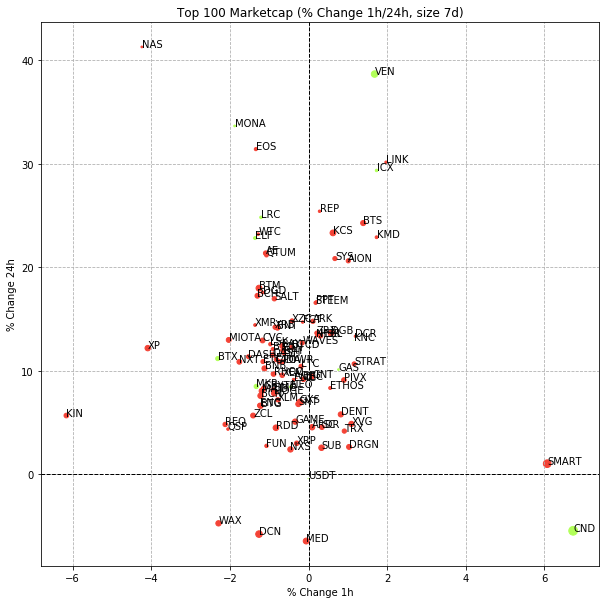

In [15]:
symbol, x, y, z = zip(*series)
color = []

for i in z:
    if(i < 0):
        color.append('#F44336')
    else:
        color.append('#B2FF59')
        
size = []

for i in z:
    size.append(math.sqrt(i**2))

plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(x, y, size, color=color)

for i, txt in enumerate(symbol):
    plt.annotate(txt, (x[i], y[i]))

plt.title('Top 100 Marketcap (% Change 1h/24h, size 7d)')
xlabel('% Change 1h')
ylabel('% Change 24h')
grid(which='major', linestyle='--')
plt.axvline(0,c='black',lw=1, linestyle='--')
plt.axhline(0,c='black',lw=1, linestyle='--')

plt.savefig('test.png')
plt.show();

## Bitcoin % from ATH

In [16]:
polo_btc_usdt = get_chart("USDT_BTC", get_unix_time_minus_days(30), _DAY)

In [17]:
polo_btc_usdt[0:2]

[{'close': 13247.06419074,
  'date': 1513900800,
  'high': 15519.79447536,
  'low': 11362.39,
  'open': 15180.00000001,
  'quoteVolume': 29968.89251945,
  'volume': 396038503.84234,
  'weightedAverage': 13214.98629237},
 {'close': 13830,
  'date': 1513987200,
  'high': 14940,
  'low': 13000,
  'open': 13200.00000001,
  'quoteVolume': 11453.33700481,
  'volume': 162555092.92983,
  'weightedAverage': 14192.81497275}]

In [18]:
d1 = parse_unix_date(polo_btc_usdt[0]['date'])

In [19]:
d = datetime.datetime.strptime("2013-1-25", '%Y-%m-%d')
print(datetime.date.strftime(d, "%m/%d/%y"))

01/25/13


In [20]:
max_close = max([float(x['close']) for x in polo_btc_usdt])
series = [(datetime.datetime.utcfromtimestamp(x['date']).strftime('%Y-%m-%d'), float(x['close'])/max_close) for x in polo_btc_usdt]

In [21]:
series[0:2]

[('2017-12-22', 0.7720306836033856), ('2017-12-23', 0.8060038209596975)]

In [22]:
import matplotlib.dates as mdates

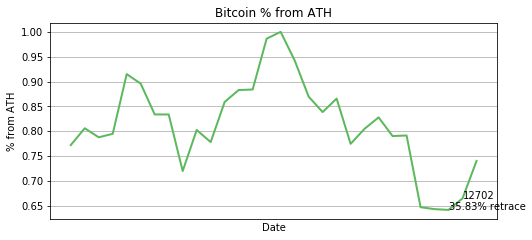

In [23]:
x, y = zip(*series)

plt.rcParams['figure.figsize'] = 8, 4
plt.plot(x, y, c='#5cb85c', lw=2.0)
plt.xticks(rotation=90)
grid()
title('Bitcoin % from ATH')
xlabel('Date')
ylabel('% from ATH')

# Max retrace (global minimum)
low = min(y)
low_index = y.index(low)
plt.annotate("%s" % round((1 - y[low_index]) * 100, 2) + '% retrace', xy=(x[low_index], y[low_index]))

# Current price 
plt.annotate("%s" % round(float(polo_btc_usdt[len(polo_btc_usdt)-1]['close'])), xy=(x[len(x)-2], y[len(y)-2]))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()

plt.show()

## Altcoin % from ATH

## Altcoin Correlation Map

## BTC Consecutive Bull Candles Markov Chain

## Heikin-Ashi Trading Strategy Signals

## Neural Network Trading Signals

## Largest spread between exchanges